# Lego Analysis

Author: M. Tosic

Date: 01.2022

This notebook is part of my capstone project for a data science course. The project is independent and has no connection to the company LEGO.

# 1. Business Understanding

Questions of interest

**A) Exploratory Analysis**
* What themes are dominant over the years?
* What words are used most often in set names?
* Most Minifigures?
* Most Lego pieces?
* Are lego sets becomming more and more expensive?
* Retial price to piece count?
* Does the value of sets go up after eol on average?
* What sets do best after eol? (eol = lego-term for end-of-life meaning the date when the set is not being produced anymore by the company).

**B) Predictive Analysis**
* What are features of the data set are good predictors that will rise in value after eol?
* What do the words contained in the set names tell us about the rise of value after eol.
* What sets that are currently being sold can I predicte to be a good investment after eol?* 

*e.g. price increase of at least 10 usd (for package and shipment when selling) + at least 25% profit

# 2. Data Understanding

Data being used in this notebook has been downloaded from the following sources:

* https://brickset.com/
* https://rebrickable.com/downloads/

Simplifications:
* No time series data on the price averages available. Assumption: price changes average out over time after eol. The price curves are already in a steady state.
* No data available on unique minifigs in sets (minifig are popular for collectors that focus on them and are generally believed to drive up the prices of some sets after eol).

### Import Libraries

In [160]:
import numpy as np
import pandas as pd

#cisualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100) #pd.set_option('display.max_rows', None)

# import necessary libraries for batch import csv:
import os
import glob

#to make api calls
import requests

### Import Data

In [161]:
df_sets = pd.read_csv('data/rebrickable-sets.csv')
df_themes = pd.read_csv('data/rebrickable-themes.csv')

In [163]:
def import_multiple_csv_files_2_df (relative_path):
    """ Function uses os and glob packages to import multiple csv files into one dataframe. 
    The current working directory should be the one where this notebook is located.
    INPUT: 
    Relative path to the files e.g. "./data/Kurac*.csv"
    OUTPUT: 
    One dataframe containting all csv files concatenated together over axis = 0.
    """
    path = os.getcwd()
    files = glob.glob(os.path.join(path, relative_path))
    
    print('Glob search with parameters:', relative_path)
   # print('Ingested files:')
    li = []
    for file in files:
        df_temp = pd.read_csv(file, index_col = None, header = 0)
        li.append(df_temp)
        #print(file)
    try:    
        df = pd.concat(li, axis=0, ignore_index=True)
        print('Done.')

    except:
        print('Something went wrong the concatenation of the files, returning None. Is the relative_path correctly set?')
        return(None)
    
    return (df)

In [202]:
df = import_multiple_csv_files_2_df("./data/Brickset*.csv")

Glob search with parameters: ./data/Brickset*.csv
Done.


**Droping unnessecary columns:**

In [203]:
df.drop(['Qty owned','UPC','Qty owned new', 
         'Qty owned used', 'EAN','Priority','Wanted', 'Height', 'Depth', 'Weight', 'Width', 
         'Notes','Qty wanted','RRP (CAD)','Flag 1 not used', 'Flag 2 not used', 'Flag 3 not used',
         'Flag 4 not used', 'Flag 5 not used', 'Flag 6 not used','Flag 7 not used', 'Flag 8 not used'], axis=1, inplace=True)

**Adapting columns names to be able to user dot notation and more intuitive code(e.g. price instead of rrp):**

In [204]:
df.rename(columns = lambda x : x.replace(' ', '_').replace('(','').replace(')','').lower().strip(), inplace = True)
df.rename(columns={'set':'set_name','rrp_usd': 'price', 'value_new_usd': 'value_new', 'value_used_usd':'value_used'});

**Checking types per column:**

In [205]:
df.dtypes

number             object
theme              object
subtheme           object
year                int64
set_name           object
minifigs          float64
pieces            float64
rrp_gbp           float64
rrp_usd           float64
rrp_eur           float64
value_new_usd     float64
value_used_usd    float64
launch_date        object
exit_date          object
dtype: object

In [206]:
#Parse dates
#df['launch_date'] = pd.to_datetime(df['launch_date'])
#df['exit_date'] = pd.to_datetime(df['exit_date'])

In [207]:
#Exploring content
df.sort_values(["year","launch_date"], inplace = True)

### Exploring Content

In [208]:
df.shape

(15634, 14)

In [209]:
df.describe()

year  minifigs    pieces  rrp_gbp   rrp_usd  rrp_eur  \
count 15,634.00  7,171.00 12,118.00 8,172.00 10,234.00 3,900.00   
mean   2,010.44      2.67    233.25    26.55     29.97    38.66   
std        8.05      2.79    470.34    39.71     44.52    56.64   
min    1,991.00      1.00      0.00     0.00      0.00     0.01   
25%    2,004.00      1.00     24.00     5.99      6.99     9.99   
50%    2,012.00      2.00     75.00    14.99     15.00    19.99   
75%    2,017.00      3.00    251.00    29.99     34.99    44.95   
max    2,022.00     33.00 11,695.00   699.99    799.99   799.99   

       value_new_usd  value_used_usd  
count      10,541.00        8,751.00  
mean           79.04           41.11  
std           213.08           75.64  
min             0.00            0.25  
25%            11.05            6.57  
50%            28.98           16.23  
75%            74.89           43.35  
max         9,773.99        1,391.39

In [210]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15634 entries, 0 to 4106
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number          15634 non-null  object 
 1   theme           15634 non-null  object 
 2   subtheme        12655 non-null  object 
 3   year            15634 non-null  int64  
 4   set_name        15634 non-null  object 
 5   minifigs        7171 non-null   float64
 6   pieces          12118 non-null  float64
 7   rrp_gbp         8172 non-null   float64
 8   rrp_usd         10234 non-null  float64
 9   rrp_eur         3900 non-null   float64
 10  value_new_usd   10541 non-null  float64
 11  value_used_usd  8751 non-null   float64
 12  launch_date     6624 non-null   object 
 13  exit_date       6624 non-null   object 
dtypes: float64(7), int64(1), object(6)
memory usage: 1.8+ MB


**Check if there are duplicated values:**

In [211]:
df[df.duplicated()]

Empty DataFrame
Columns: [number, theme, subtheme, year, set_name, minifigs, pieces, rrp_gbp, rrp_usd, rrp_eur, value_new_usd, value_used_usd, launch_date, exit_date]
Index: []

**Unique values per column:**

In [212]:
df.nunique().sort_values(ascending = True)

minifigs             31
year                 32
theme               141
rrp_eur             143
exit_date           165
rrp_gbp             270
rrp_usd             322
launch_date         404
subtheme            801
pieces             1332
value_used_usd     4522
value_new_usd      6178
set_name          13328
number            15634
dtype: int64

**Investigate missing values in data set:**

In [213]:
print("Percentages of missing values:\n{}".format(df.isnull().sum()/df.shape[0]*100))

Percentages of missing values:
number            0.00
theme             0.00
subtheme         19.05
year              0.00
set_name          0.00
minifigs         54.13
pieces           22.49
rrp_gbp          47.73
rrp_usd          34.54
rrp_eur          75.05
value_new_usd    32.58
value_used_usd   44.03
launch_date      57.63
exit_date        57.63
dtype: float64


In [214]:
df_missing_val_per = pd.DataFrame(df.isnull().sum()/df.shape[0]*100, columns=['value'])
df_missing_val_per_sorted = df_missing_val_per.sort_values(by = "value", ascending = False)

In [215]:
px.bar(df_missing_val_per_sorted, 
       x = df_missing_val_per_sorted.index, 
       y = "value", 
       labels = {"value":"percentage of missing values"})


**Comments:**
* There are NaN values in most columns.
* Most values are missing in rrp_eur, but this is ok since the analysis will be done in usd (due to value_new and value_used also being in usd). The available rrp_eur values can be used to fill-in missing data in the usd column.
* More than half of the items don't have a launch and exit date.
* The missing values for minifigs could just be due to the items being lego sets without any minifigures or those are other lego product merchendise.

**Tasks:**
* A quarter of the items are missing piece counts. This must be investigated since it could indicate the item is not a lego set but some other kind of merchandise from the database. I will aim to categorize the items into sets and other merchendise. A possible way to does this is to use the pieces count >0 or minifigure >0.

* Most prices are available in usd, also the value new and used is available in usd. If possible I will try to calculate missing values in usd by the columns of other currencies then drop the other columns to reduce complexity for further processing (one currency is enough for the inteded analysis).

* Also some dates are missing, I'll take a look at that. Sets from 2022 have probably not yet been released, I will label them as not released. The items that have a launch date but no exit date will be labeled as active, items that have an exit date will be label eol (popular lego term "end-of-life" for items that are no longer produced).

**Make box-plots of all columns with numerival values:**

In [216]:
for col in df.columns:
    if df[col].dtype == np.int64 or df[col].dtype == np.float64:
        print(col)
        fig = px.box(df, x = col, points="all")
        fig.update_yaxes(visible = False, showticklabels = False)
        fig.show()
    else:
        continue

year


minifigs


pieces


rrp_gbp


rrp_usd


rrp_eur


value_new_usd


value_used_usd


**Comments**
* Year: The median is 2012 meaning that half of the items in the data-set containing the past 30th years were released in the past 9 years.
* Minifing: Median is only 2. This should be investigated in more detail since data set includes lego items that are not necessarily sets but other merchandice.
* Pieces: Similare goes for the rather low median of pieces. 

**Task**
* Task categorize entries as sets very other merchandice.

In [217]:
px.scatter(df, x = "year", y = "theme", color = "theme")

In [218]:
px.histogram(df.groupby("year"), x = df.launch_date)

<AxesSubplot:>

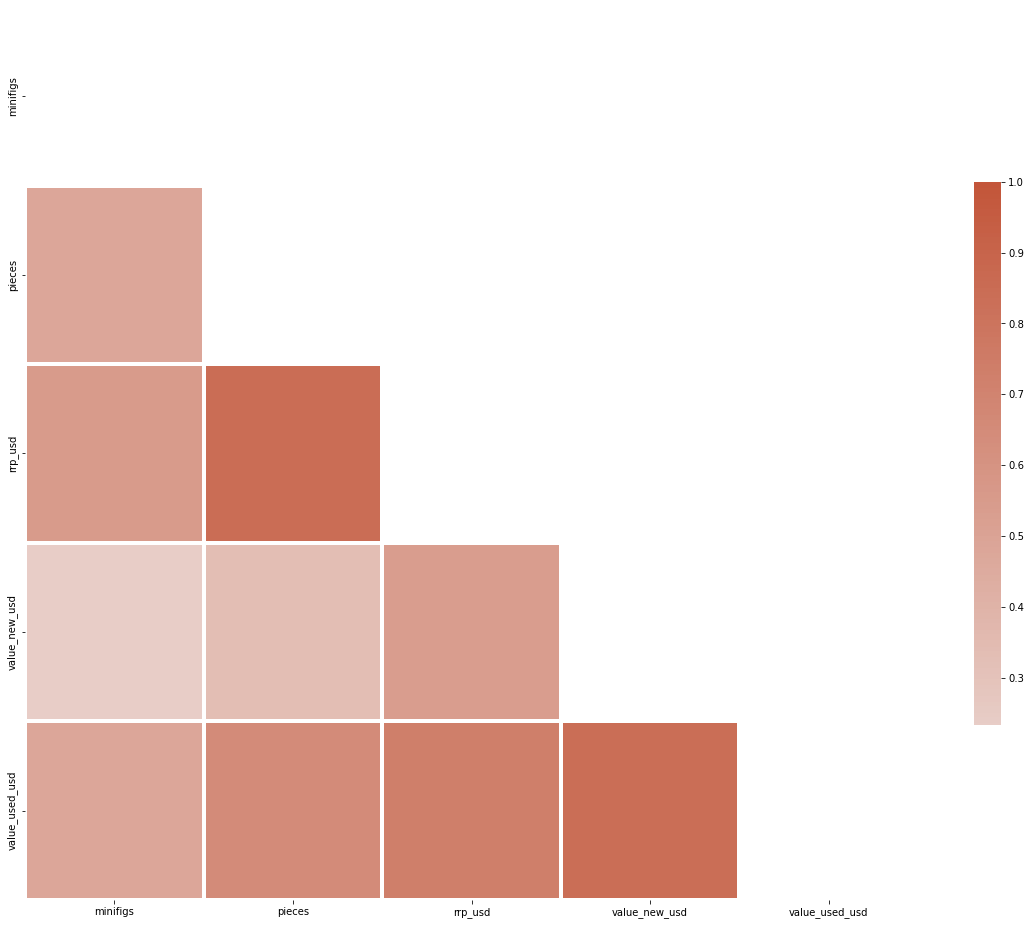

In [219]:
corr = df.drop(["year","rrp_gbp","rrp_eur"], axis = "columns").corr()
mask = np.triu(np.ones_like(corr, dtype = bool))

f, ax = plt.subplots(figsize = (20,20))

cmap = sns.diverging_palette(200, 20, as_cmap = True)
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = 1, center = 0, square = True, linewidth = 4, cbar_kws = {"shrink":.5})


## 3. Prepare Data

### Removing rows where there is no numeric data

In [223]:
cond = df[['minifigs','pieces',
       "rrp_gbp", "rrp_eur", "rrp_usd", 
       "value_new_usd", "value_used_usd", 
       "launch_date", "exit_date"]].isnull().values.all(axis=1)
df['numeric_data_nan'] = np.where(cond, True, False)
df[df["numeric_data_nan"] == True].head()

Empty DataFrame
Columns: [number, theme, subtheme, year, set_name, minifigs, pieces, rrp_gbp, rrp_usd, rrp_eur, value_new_usd, value_used_usd, launch_date, exit_date, numeric_data_nan]
Index: []

In [224]:
df = df[df["numeric_data_nan"] == False]

In [225]:
df.head()

number     theme                subtheme  year  \
0   819-1     Basic         Supplementaries  1991   
1  1040-1     Dacta                     NaN  1991   
2  1474-1     Basic  Universal Building Set  1991   
3  1475-1      Town                  Flight  1991   
4  1476-1  Assorted        Bonus/Value Pack  1991   

                            set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
0                     Blue baseplate       NaN    1.00      NaN     5.50   
1                               Farm      4.00   89.00      NaN      NaN   
2  Basic Building Set with Gift Item      1.00   69.00      NaN      NaN   
3             Airport Security Squad      2.00  123.00      NaN    10.00   
4                Five Set Bonus Pack       NaN  158.00      NaN      NaN   

   rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
0      NaN           6.26             NaN         NaN       NaN   
1      NaN            NaN             NaN         NaN       NaN   
2      NaN          24.64             NaN         NaN       NaN   
3      NaN         165.90           49.80         NaN       NaN   
4      NaN         450.00          100.00         NaN       NaN   

   numeric_data_nan  
0             False  
1             False  
2             False  
3             False  
4             False

### Categorization of items to sets and minifigures while removing items such as gear, books, etc.

**Adding category column with value set for all items with > 0 number of pieces:**

In [226]:
df['category'] = np.where(df['pieces'] > 0, "set", "uncategorized")
df[df.category == "uncategorized"].describe()

year  minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
count 2,369.00    125.00   14.00 1,453.00 1,792.00   706.00         128.00   
mean  2,013.12      2.10    0.00    13.06    18.02    14.73         114.55   
std       5.43      2.99    0.00    21.19    23.15    26.12         413.19   
min   1,997.00      1.00    0.00     0.00     0.00     1.99           1.36   
25%   2,009.00      1.00    0.00     3.99     4.99     4.99           5.56   
50%   2,014.00      1.00    0.00     6.99    11.99     6.99          12.90   
75%   2,018.00      2.00    0.00    14.99    24.99    14.99          65.39   
max   2,022.00     24.00    0.00   274.99   299.99   304.99       3,432.84   

       value_used_usd  
count           47.00  
mean            33.08  
std             92.03  
min              2.73  
25%              4.00  
50%              5.04  
75%             14.24  
max            499.00

**Dealing with uncategorized items:**

In [227]:
uncat_themes = set(df[(df.category == "uncategorized")].theme)
print(uncat_themes)

{'Clikits', 'Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 'Legends of Chima', 'Marvel Super Heroes', 'Education', 'Make and Create', 'Books', 'Creator Expert', 'Collectable Minifigures', 'Power Miners', 'Super Mario', 'Sports', 'Technic', 'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty'}


In [228]:
for theme in uncat_themes:
    cond_2 = (df.theme == theme) & (df.category == "uncategorized")
    print("Theme:", theme)
    print("Number of rows:", df[cond_2].shape[0])
    display(df[cond_2])

Theme: Clikits
Number of rows: 1


number    theme  subtheme  year                 set_name  minifigs  \
14672  7575-1  Clikits  Seasonal  2004  Clikits Advent Calendar       NaN   

       pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd  \
14672     NaN    11.99    15.00      NaN          18.75             NaN   

      launch_date   exit_date  numeric_data_nan       category  
14672  01/10/2004  31/12/2006             False  uncategorized

Theme: Star Wars
Number of rows: 2


number      theme            subtheme  year  \
13369  PROMOSW002-1  Star Wars         Promotional  2005   
1586        66674-1  Star Wars  Product Collection  2021   

                                                set_name  minifigs  pieces  \
13369  Anakin Skywalker (International Toy Fair 2005 ...       NaN     NaN   
1586                           Skywalker Adventures Pack       NaN     NaN   

       rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date  \
13369      NaN     0.00      NaN            NaN             NaN         NaN   
1586       NaN      NaN      NaN          66.58             NaN  01/11/2021   

        exit_date  numeric_data_nan       category  
13369         NaN             False  uncategorized  
1586   31/12/2021             False  uncategorized

Theme: DC Comics Super Heroes
Number of rows: 2


number                   theme            subtheme  year  \
7594  5004816-1  DC Comics Super Heroes  Product Collection  2015   
3631   212010-1  DC Comics Super Heroes       Magazine Gift  2020   

                        set_name  minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  \
7594  Super Heroes DC Collection       NaN     NaN      NaN   149.98      NaN   
3631                      Batman      1.00     NaN      NaN      NaN      NaN   

      value_new_usd  value_used_usd launch_date exit_date  numeric_data_nan  \
7594            NaN             NaN         NaN       NaN             False   
3631           3.38            2.73         NaN       NaN             False   

           category  
7594  uncategorized  
3631  uncategorized

Theme: City
Number of rows: 2


number theme            subtheme  year                 set_name  \
10130    66540-1  City   Volcano Explorers  2016  City Volcano Value Pack   
4806   5005554-1  City  Product Collection  2018  LEGO City Easter Bundle   

       minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
10130       NaN     NaN      NaN      NaN      NaN          88.23   
4806        NaN     NaN    37.97      NaN    44.97            NaN   

       value_used_usd launch_date   exit_date  numeric_data_nan       category  
10130           55.18  01/09/2016  31/12/2016             False  uncategorized  
4806              NaN         NaN         NaN             False  uncategorized

Theme: The LEGO Movie 2
Number of rows: 2


number             theme       subtheme  year          set_name  \
5435   471906-1  The LEGO Movie 2  Magazine Gift  2019  Rex with Jetpack   
5582  5005738-1  The LEGO Movie 2            NaN  2019      Sticker roll   

      minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
5435      1.00     NaN      NaN      NaN      NaN           3.19   
5582       NaN     NaN     3.99     3.99     3.99            NaN   

      value_used_usd launch_date exit_date  numeric_data_nan       category  
5435             NaN         NaN       NaN             False  uncategorized  
5582             NaN         NaN       NaN             False  uncategorized

Theme: Legends of Chima
Number of rows: 19


number             theme       subtheme  year  \
6617  391214-1  Legends of Chima  Magazine gift  2014   
6619  391404-1  Legends of Chima  Magazine gift  2014   
6620  391405-1  Legends of Chima  Magazine gift  2014   
6621  391406-1  Legends of Chima  Magazine gift  2014   
6622  391407-1  Legends of Chima  Magazine gift  2014   
6623  391408-1  Legends of Chima  Magazine gift  2014   
6624  391409-1  Legends of Chima  Magazine gift  2014   
6625  391410-1  Legends of Chima  Magazine gift  2014   
6626  391411-1  Legends of Chima  Magazine gift  2014   
6627  391412-1  Legends of Chima  Magazine gift  2014   
6628  471408-1  Legends of Chima  Magazine gift  2014   
7412  391501-1  Legends of Chima  Magazine gift  2015   
7413  391502-1  Legends of Chima  Magazine gift  2015   
7414  391503-1  Legends of Chima  Magazine gift  2015   
7415  391504-1  Legends of Chima  Magazine gift  2015   
7416  391505-1  Legends of Chima  Magazine gift  2015   
7417  391506-1  Legends of Chima  Magazine gift  2015   
7418  391507-1  Legends of Chima  Magazine gift  2015   
7419  391508-1  Legends of Chima  Magazine gift  2015   

                                   set_name  minifigs  pieces  rrp_gbp  \
6617                          Speedorz Ramp       NaN     NaN      NaN   
6619                                 Worriz       NaN     NaN      NaN   
6620                      Crocodile Hideout       NaN     NaN      NaN   
6621  Crug minifigure with armour and sword       NaN     NaN      NaN   
6622                  Fire spinner and ramp       NaN     NaN      NaN   
6623                                 Vornon       NaN     NaN      NaN   
6624                             Ice Prison       NaN     NaN      NaN   
6625                                  Sykor       NaN     NaN      NaN   
6626                                Shooter       NaN     NaN      NaN   
6627                                 Worriz       NaN     NaN      NaN   
6628                Lennox with Lion Cannon       NaN     NaN      NaN   
7412                                 Gorzan       NaN     NaN      NaN   
7413             Saber-tooth tribe launcher       NaN     NaN      NaN   
7414                                 Lundor       NaN     NaN      NaN   
7415                   Fire and Ice weapons       NaN     NaN      NaN   
7416                                Iceklaw       NaN     NaN      NaN   
7417                         Fire Catapault       NaN     NaN      NaN   
7418                              Stealthor       NaN     NaN      NaN   
7419                                 Bulkar       NaN     NaN      NaN   

      rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
6617      NaN      NaN           2.37             NaN         NaN       NaN   
6619      NaN      NaN           6.22             NaN         NaN       NaN   
6620      NaN      NaN           1.63             NaN         NaN       NaN   
6621      NaN      NaN           2.50             NaN         NaN       NaN   
6622      NaN      NaN           3.96             NaN         NaN       NaN   
6623      NaN      NaN           2.54            3.75         NaN       NaN   
6624      NaN      NaN           1.36             NaN         NaN       NaN   
6625      NaN      NaN           3.81             NaN         NaN       NaN   
6626      NaN      NaN           1.84             NaN         NaN       NaN   
6627      NaN      NaN           2.40             NaN         NaN       NaN   
6628      NaN      NaN           5.13             NaN         NaN       NaN   
7412      NaN      NaN           6.80             NaN         NaN       NaN   
7413      NaN      NaN           2.45             NaN         NaN       NaN   
7414      NaN      NaN           3.21             NaN         NaN       NaN   
7415      NaN      NaN           2.56             NaN         NaN       NaN   
7416      NaN      NaN           2.70             NaN         NaN       NaN   
7417      NaN      NaN           2.04      

Theme: Marvel Super Heroes
Number of rows: 1


number                theme       subtheme  year  set_name  minifigs  \
4076  242210-1  Marvel Super Heroes  Magazine Gift  2022  Iron Man       NaN   

      pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd  \
4076     NaN      NaN      NaN      NaN           5.04             NaN   

     launch_date exit_date  numeric_data_nan       category  
4076         NaN       NaN             False  uncategorized

Theme: Education
Number of rows: 9


number      theme           subtheme  year  \
9282    9412-1  Education              Duplo  2003   
12048   9310-1  Education                NaN  2007   
12492  45080-1  Education                NaN  2013   
8378   45497-1  Education            Storage  2017   
8379   45498-1  Education                NaN  2017   
1541   45816-1  Education  FIRST LEGO League  2021   
1542   45817-1  Education  FIRST LEGO League  2021   
1533   45345-1  Education    SPIKE Essential  2021   
1538   45609-1  Education        SPIKE Prime  2021   

                          set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
9282                  Duplo Bricks       NaN     NaN    28.99      NaN   
12048                Dinosaurs Set       NaN     NaN      NaN      NaN   
12492               Creative Cards       NaN     NaN      NaN      NaN   
8378      Storage boxes, pack of 7       NaN     NaN      NaN      NaN   
8379        Medium storage, 8 pack       NaN     NaN      NaN      NaN   
1541   FIRST LEGO League Challenge       NaN     NaN      NaN      NaN   
1542     Cargo Connect Explore Set       NaN     NaN      NaN      NaN   
1533           SPIKE Essential Set       NaN     NaN   274.99   274.95   
1538                     Small Hub       NaN     NaN   189.99   189.95   

       rrp_eur  value_new_usd  value_used_usd launch_date   exit_date  \
9282       NaN            NaN             NaN         NaN         NaN   
12048      NaN            NaN           89.99         NaN         NaN   
12492      NaN           6.57             NaN         NaN         NaN   
8378       NaN          74.92             NaN         NaN         NaN   
8379       NaN         111.49             NaN         NaN         NaN   
1541       NaN            NaN             NaN  01/08/2021  31/12/2023   
1542       NaN            NaN             NaN  01/08/2021  31/12/2023   
1533    304.99         380.61             NaN         NaN         NaN   
1538    209.99            NaN             NaN         NaN         NaN   

       numeric_data_nan       category  
9282              False  uncategorized  
12048             False  uncategorized  
12492             False  uncategorized  
8378              False  uncategorized  
8379              False  uncategorized  
1541              False  uncategorized  
1542              False  uncategorized  
1533              False  uncategorized  
1538              False  uncategorized

Theme: Make and Create
Number of rows: 1


number            theme subtheme  year                 set_name  \
11514  7794-1  Make and Create      NaN  2006  {Set with two minifigs}   

       minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
11514       NaN     NaN    19.99      NaN      NaN            NaN   

       value_used_usd launch_date exit_date  numeric_data_nan       category  
11514             NaN         NaN       NaN             False  uncategorized

Theme: Books
Number of rows: 100


number  theme                subtheme  year  \
5988                4006-1  Books                    LEGO  2000   
5989                4007-1  Books                    LEGO  2000   
3023     BRICKJOURNAL001-1  Books  Magazines/BrickJournal  2008   
3024     BRICKJOURNAL002-1  Books  Magazines/BrickJournal  2008   
3025     BRICKJOURNAL003-1  Books  Magazines/BrickJournal  2008   
3026     BRICKJOURNAL004-1  Books  Magazines/BrickJournal  2008   
3038   ISBN9783935976534-1  Books    Fantasia Verlag GmbH  2008   
2566     BRICKJOURNAL005-1  Books  Magazines/BrickJournal  2009   
2567     BRICKJOURNAL006-1  Books  Magazines/BrickJournal  2009   
2568     BRICKJOURNAL007-1  Books  Magazines/BrickJournal  2009   
2569     BRICKJOURNAL008-1  Books  Magazines/BrickJournal  2009   
2594   ISBN9780756655198-1  Books      Dorling Kindersley  2009   
2595   ISBN9780756672812-1  Books      Dorling Kindersley  2009   
14445    BRICKJOURNAL009-1  Books  Magazines/BrickJournal  2010   
14446    BRICKJOURNAL010-1  Books  Magazines/BrickJournal  2010   
14447    BRICKJOURNAL011-1  Books  Magazines/BrickJournal  2010   
14448    BRICKJOURNAL012-1  Books  Magazines/BrickJournal  2010   
14458  ISBN9780756663117-1  Books      Dorling Kindersley  2010   
14459  ISBN9780756668532-1  Books      Dorling Kindersley  2010   
14460  ISBN9781591747697-1  Books                   Klutz  2010   
13902    BRICKJOURNAL013-1  Books  Magazines/BrickJournal  2011   
13903    BRICKJOURNAL014-1  Books  Magazines/BrickJournal  2011   
13904    BRICKJOURNAL015-1  Books  Magazines/BrickJournal  2011   
13905    BRICKJOURNAL016-1  Books  Magazines/BrickJournal  2011   
13918  ISBN9780756682767-1  Books      Dorling Kindersley  2011   
13919  ISBN9780756686062-1  Books      Dorling Kindersley  2011   
13921  ISBN9781405356237-1  Books      Dorling Kindersley  2011   
11309    BRICKJOURNAL017-1  Books  Magazines/BrickJournal  2012   
11310    BRICKJOURNAL018-1  Books  Magazines/BrickJournal  2012   
11311    BRICKJOURNAL019-1  Books  Magazines/BrickJournal  2012   
11312    BRICKJOURNAL020-1  Books  Magazines/BrickJournal  2012   
11313    BRICKJOURNAL021-1  Books  Magazines/BrickJournal  2012   
12906    BRICKJOURNAL022-1  Books  Magazines/BrickJournal  2013   
12907    BRICKJOURNAL023-1  Books  Magazines/BrickJournal  2013   
12908    BRICKJOURNAL024-1  Books  Magazines/BrickJournal  2013   
12909    BRICKJOURNAL025-1  Books  Magazines/BrickJournal  2013   
12910    BRICKJOURNAL026-1  Books  Magazines/BrickJournal  2013   
12934  ISBN9781409327516-1  Books      Dorling Kindersley  2013   
6838     BRICKJOURNAL027-1  Books  Magazines/BrickJournal  2014   
6839     BRICKJOURNAL028-1  Books  Magazines/BrickJournal  2014   
6840     BRICKJOURNAL029-1  Books  Magazines/BrickJournal  2014   
6841     BRICKJOURNAL030-1  Books  Magazines/BrickJournal  2014   
6842     BRICKJOURNAL031-1  Books  Magazines/BrickJournal  2014   
7635     BRICKJOURNAL032-1  Books  Magazines/BrickJournal  2015   
7636     BRICKJOURNAL033-1  Books  Magazines/BrickJournal  2015   
7637     BRICKJOURNAL034-1  Books  Magazines/BrickJournal  2015   
7638     BRICKJOURNAL035-1  Books  Magazines/BrickJournal  2015   
7639     BRICKJOURNAL036-1  Books  Magazines/BrickJournal  2015   
7640     BRICKJOURNAL037-1  Books  Magazines/BrickJournal  2015   
7652   ISBN9780241182987-1  Books      Dorling Kindersley  2015   
7660   ISBN9781409355724-1  Books      Dorling Kindersley  2015   
7663   ISBN9781465434371-1  Books      Dorling Kindersley  2015   
10620    BRICKJOURNAL038-1  Books  Magazines/BrickJournal  2016   
10621    BRICKJOURNAL039-1  Books  Magazines/BrickJournal  2016   
10622    BRICKJOURNAL040-1  Books  Magazines/BrickJournal  2016   
10623    BRICKJOURNAL041-1  Books  Magazines/BrickJournal  2016   
10624    BRICKJOURNAL042-1  Books  Magazines/BrickJournal  2016   
8898     BRICKJOURNAL043-1  Books  Magazines/BrickJournal  2017   
8899     BRICKJOURNAL044-1  Books  Magazines/BrickJournal  2017   


Theme: Creator Expert
Number of rows: 1


number           theme subtheme  year  \
1229  10282-2  Creator Expert   Adidas  2021   

                                               set_name  minifigs  pieces  \
1229  Adidas Originals Superstar X Footshop 'Bluepri...       NaN     NaN   

      rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date  \
1229    79.99    79.99    89.99            NaN             NaN  01/07/2021   

       exit_date  numeric_data_nan       category  
1229  31/12/2023             False  uncategorized

Theme: Collectable Minifigures
Number of rows: 68


number                    theme                        subtheme  \
14162    8683-0  Collectable Minifigures                        Series 1   
14180   8683-18  Collectable Minifigures                        Series 1   
14181    8684-0  Collectable Minifigures                        Series 2   
14199   8684-18  Collectable Minifigures                        Series 2   
13594    8803-0  Collectable Minifigures                        Series 3   
13612   8803-18  Collectable Minifigures                        Series 3   
13613    8804-0  Collectable Minifigures                        Series 4   
13631   8804-18  Collectable Minifigures                        Series 4   
13632    8805-0  Collectable Minifigures                        Series 5   
13650   8805-18  Collectable Minifigures                        Series 5   
10826    8827-0  Collectable Minifigures                        Series 6   
10844   8827-18  Collectable Minifigures                        Series 6   
10845    8831-0  Collectable Minifigures                        Series 7   
10863   8831-18  Collectable Minifigures                        Series 7   
10883    8909-0  Collectable Minifigures                         Team GB   
10864    8833-0  Collectable Minifigures                        Series 8   
10882   8833-18  Collectable Minifigures                        Series 8   
12638  71000-18  Collectable Minifigures                        Series 9   
12639   71001-0  Collectable Minifigures                       Series 10   
12657  71001-18  Collectable Minifigures                       Series 10   
12677  71002-18  Collectable Minifigures                       Series 11   
6502    71004-0  Collectable Minifigures                  The LEGO Movie   
6520   71004-18  Collectable Minifigures                  The LEGO Movie   
6521    71005-0  Collectable Minifigures                    The Simpsons   
6539   71005-18  Collectable Minifigures                    The Simpsons   
6541    71007-0  Collectable Minifigures                       Series 12   
6559   71007-18  Collectable Minifigures                       Series 12   
7263   71008-18  Collectable Minifigures                       Series 13   
7264    71009-0  Collectable Minifigures           The Simpsons Series 2   
7282   71009-18  Collectable Minifigures           The Simpsons Series 2   
7283    71010-0  Collectable Minifigures            Series 14 - Monsters   
7301   71010-18  Collectable Minifigures            Series 14 - Monsters   
10182   71011-0  Collectable Minifigures                       Series 15   
10200  71011-18  Collectable Minifigures                       Series 15   
10201   71012-0  Collectable Minifigures                          Disney   
10221  71012-20  Collectable Minifigures                          Disney   
10241   71014-0  Collectable Minifigures                      DFB Series   
10259  71014-18  Collectable Minifigures                      DFB Series   
10222   71013-0  Collectable Minifigures                       Series 16   
10240  71013-18  Collectable Minifigures                       Series 16   
8492    71017-0  Collectable Minifigures           The LEGO Batman Movie   
8514   71017-22  Collectable Minifigures           The LEGO Batman Movie   
8515    71018-0  Collectable Minifigures                       Series 17   
8533   71018-18  Collectable Minifigures                       Series 17   
8534    71019-0  Collectable Minifigures          The LEGO Ninjago Movie   
8556   71019-22  Collectable Minifigures          The LEGO Ninjago Movie   
4469    71020-0  Collectable Minifigures  The LEGO Batman Movie Series 2   
4491   71020-22  Collectable Minifigures  The LEGO Batman Movie Series 2   
4492    71021-0  Collectable Minifigures                       Series 18   
4511   71021-19  Collectable Minifigures                       Series 18   
4512    71022-0  Collectable Minifigures                    Harry Potter   
4536   71022-24  Collectable Minifigures                 

Theme: Power Miners
Number of rows: 3


number         theme     subtheme  year  \
2556  4559288-1  Power Miners  Promotional  2009   
2557  4559385-1  Power Miners  Promotional  2009   
2558  4559387-1  Power Miners  Promotional  2009   

                                set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
2556  {Power Miners Promotional Polybag}      1.00     NaN      NaN      NaN   
2557  {Power Miners Promotional Polybag}      1.00     NaN      NaN      NaN   
2558  {Power Miners Promotional Polybag}      1.00     NaN      NaN      NaN   

      rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
2556      NaN          29.50             NaN         NaN       NaN   
2557      NaN          14.63             NaN         NaN       NaN   
2558      NaN           9.26             NaN         NaN       NaN   

      numeric_data_nan       category  
2556             False  uncategorized  
2557             False  uncategorized  
2558             False  uncategorized

Theme: Super Mario
Number of rows: 54


number        theme                   subtheme  year  \
3468    71361-0  Super Mario  Character Pack - Series 1  2020   
3469    71361-1  Super Mario  Character Pack - Series 1  2020   
3470    71361-2  Super Mario  Character Pack - Series 1  2020   
3471    71361-3  Super Mario  Character Pack - Series 1  2020   
3472    71361-4  Super Mario  Character Pack - Series 1  2020   
3473    71361-5  Super Mario  Character Pack - Series 1  2020   
3474    71361-6  Super Mario  Character Pack - Series 1  2020   
3475    71361-7  Super Mario  Character Pack - Series 1  2020   
3476    71361-8  Super Mario  Character Pack - Series 1  2020   
3477    71361-9  Super Mario  Character Pack - Series 1  2020   
3478   71361-10  Super Mario  Character Pack - Series 1  2020   
3479   71361-11  Super Mario  Character Pack - Series 1  2020   
3480   71361-12  Super Mario  Character Pack - Series 1  2020   
1643    71386-0  Super Mario  Character Pack - Series 2  2021   
1644    71386-1  Super Mario  Character Pack - Series 2  2021   
1645    71386-2  Super Mario  Character Pack - Series 2  2021   
1646    71386-3  Super Mario  Character Pack - Series 2  2021   
1647    71386-4  Super Mario  Character Pack - Series 2  2021   
1648    71386-5  Super Mario  Character Pack - Series 2  2021   
1649    71386-6  Super Mario  Character Pack - Series 2  2021   
1650    71386-7  Super Mario  Character Pack - Series 2  2021   
1651    71386-8  Super Mario  Character Pack - Series 2  2021   
1652    71386-9  Super Mario  Character Pack - Series 2  2021   
1653   71386-10  Super Mario  Character Pack - Series 2  2021   
1654   71386-11  Super Mario  Character Pack - Series 2  2021   
1655   71386-12  Super Mario  Character Pack - Series 2  2021   
1663    71394-0  Super Mario  Character Pack - Series 3  2021   
1664    71394-1  Super Mario  Character Pack - Series 3  2021   
1665    71394-2  Super Mario  Character Pack - Series 3  2021   
1666    71394-3  Super Mario  Character Pack - Series 3  2021   
1667    71394-4  Super Mario  Character Pack - Series 3  2021   
1668    71394-5  Super Mario  Character Pack - Series 3  2021   
1669    71394-6  Super Mario  Character Pack - Series 3  2021   
1670    71394-7  Super Mario  Character Pack - Series 3  2021   
1671    71394-8  Super Mario  Character Pack - Series 3  2021   
1672    71394-9  Super Mario  Character Pack - Series 3  2021   
1673   71394-10  Super Mario  Character Pack - Series 3  2021   
1674   71394-11  Super Mario  Character Pack - Series 3  2021   
1675   71394-12  Super Mario  Character Pack - Series 3  2021   
2056  5007060-1  Super Mario         Product Collection  2021   
2057  5007061-1  Super Mario         Product Collection  2021   
2058  5007062-1  Super Mario         Product Collection  2021   
4035    71402-0  Super Mario  Character Pack - Series 4  2022   
4036    71402-1  Super Mario  Character Pack - Series 4  2022   
4037    71402-2  Super Mario  Character Pack - Series 4  2022   
4038    71402-3  Super Mario  Character Pack - Series 4  2022   
4039    71402-4  Super Mario  Character Pack - Series 4  2022   
4040    71402-5  Super Mario  Character Pack - Series 4  2022   
4041    71402-6  Super Mario  Character Pack - Series 4  2022   
4042    71402-7  Super Mario  Character Pack - Series 4  2022   
4043    71402-8  Super Mario  Character Pack - Series 4  2022   
4044    71402-9  Super Mario  Character Pack - Series 4  2022   
4045   71402-10  Super Mario  Character Pack - Series 4  2022   
4046   71402-12  Super Mario  Character Pack - Series 4  2022   

                                    set_name  minifigs  pieces  rrp_gbp  \
3468  Character Pack - Series 1 {Random bag}       NaN     NaN      NaN   
3469                              Paragoomba      1.00     NaN      NaN   
3470                                   Fuzzy      1.00     NaN      NaN   
3471                                   Spiny      1.00     NaN      NaN   
3472                            Buzzy Beetle      1.00    

Theme: Sports
Number of rows: 1


number   theme  subtheme  year         set_name  minifigs  pieces  \
5896  3406-2  Sports  Football  2000  French Team Bus       NaN     NaN   

      rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date  \
5896      NaN      NaN      NaN            NaN             NaN  01/04/2000   

       exit_date  numeric_data_nan       category  
5896  30/06/2002             False  uncategorized

Theme: Technic
Number of rows: 1


number    theme subtheme  year    set_name  minifigs  pieces  rrp_gbp  \
662  8299-1  Technic      NaN  1997  Search Sub      1.00    0.00      NaN   

     rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
662    50.00      NaN         108.62           61.46         NaN       NaN   

     numeric_data_nan       category  
662             False  uncategorized

Theme: Ninjago
Number of rows: 1


number    theme            subtheme  year  \
4804  5005552-1  Ninjago  Product Collection  2018   

                        set_name  minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  \
4804  LEGO NINJAGO Easter Bundle       NaN     NaN    42.95      NaN    44.95   

      value_new_usd  value_used_usd launch_date exit_date  numeric_data_nan  \
4804            NaN             NaN         NaN       NaN             False   

           category  
4804  uncategorized

Theme: Vidiyo
Number of rows: 4


number   theme            subtheme  year  \
1475   43101-0  Vidiyo  Bandmates Series 1  2021   
1489  43101-14  Vidiyo  Bandmates Series 1  2021   
1496   43108-0  Vidiyo  Bandmates Series 2  2021   
1510  43108-14  Vidiyo  Bandmates Series 2  2021   

                             set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
1475  Bandmates Series 1 {Random box}       NaN     NaN     3.99     4.99   
1489  Bandmates Series 1 - Sealed Box       NaN     NaN     3.99     4.99   
1496  Bandmates Series 2 {Random box}       NaN     NaN     3.99     4.99   
1510  Bandmates Series 2 - Sealed Box       NaN     NaN     4.49     4.99   

      rrp_eur  value_new_usd  value_used_usd launch_date   exit_date  \
1475     4.99            NaN             NaN  01/03/2021  31/12/2022   
1489     4.99            NaN             NaN  01/03/2021  31/12/2022   
1496     4.99            NaN             NaN  01/10/2021  31/12/2022   
1510     4.99            NaN             NaN  01/10/2021  31/12/2022   

      numeric_data_nan       category  
1475             False  uncategorized  
1489             False  uncategorized  
1496             False  uncategorized  
1510             False  uncategorized

Theme: Disney
Number of rows: 4


number   theme       subtheme  year                       set_name  \
1834  302102-1  Disney  Magazine Gift  2021           Rapunzel & Hairbrush   
1835  302103-1  Disney  Magazine Gift  2021           Cinderella's Kitchen   
1837  302105-1  Disney  Magazine Gift  2021  Lumiere, Cogsworth and Sultan   
1838  302106-1  Disney  Magazine Gift  2021                 Princess Ariel   

      minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
1834       NaN     NaN      NaN      NaN      NaN           3.66   
1835       NaN     NaN      NaN      NaN      NaN           3.39   
1837       NaN     NaN      NaN      NaN      NaN           3.90   
1838       NaN     NaN      NaN      NaN      NaN           4.62   

      value_used_usd launch_date exit_date  numeric_data_nan       category  
1834             NaN         NaN       NaN             False  uncategorized  
1835             NaN         NaN       NaN             False  uncategorized  
1837             NaN         NaN       NaN             False  uncategorized  
1838             NaN         NaN       NaN             False  uncategorized

Theme: Miscellaneous
Number of rows: 6


number          theme                    subtheme  year  \
13356  LIT2005-1  Miscellaneous  LEGO Inside Tour Exclusive  2005   
8769   4000024-1  Miscellaneous  LEGO Inside Tour Exclusive  2017   
4743   4000025-1  Miscellaneous  LEGO Inside Tour Exclusive  2018   
5559   4000034-1  Miscellaneous  LEGO Inside Tour Exclusive  2019   
3105     11929-1  Miscellaneous                         NaN  2020   
3106     11930-1  Miscellaneous                         NaN  2020   

                            set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
13356                LECA Automobile       NaN     NaN      NaN      NaN   
8769   LEGO House Tree of Creativity       NaN     NaN      NaN      NaN   
4743           LEGO Ferguson Tractor       NaN     NaN      NaN      NaN   
5559               LEGO System House       NaN     NaN      NaN      NaN   
3105   Parts for The LEGO Games Book       NaN    0.00      NaN      NaN   
3106       Parts for Halloween Ideas       NaN    0.00      NaN      NaN   

       rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
13356      NaN       1,227.20             NaN         NaN       NaN   
8769       NaN       1,960.86             NaN         NaN       NaN   
4743       NaN       2,300.00             NaN         NaN       NaN   
5559       NaN       3,432.84             NaN         NaN       NaN   
3105       NaN            NaN             NaN         NaN       NaN   
3106       NaN            NaN             NaN         NaN       NaN   

       numeric_data_nan       category  
13356             False  uncategorized  
8769              False  uncategorized  
4743              False  uncategorized  
5559              False  uncategorized  
3105              False  uncategorized  
3106              False  uncategorized

Theme: Gear
Number of rows: 1989


number theme                 subtheme  year  \
678       9708-1  Gear                Education  1997   
15096     3978-1  Gear        Key Chains/Castle  1998   
15154     5701-1  Gear           Video Games/PC  1998   
15155     5702-1  Gear           Video Games/PC  1998   
15515     5703-1  Gear  Video Games/Nintendo 64  1999   
...          ...   ...                      ...   ...   
4093   5007181-1  Gear               Housewares  2022   
4094   5007182-1  Gear               Housewares  2022   
4095   5007183-1  Gear               Housewares  2022   
4096   5007184-1  Gear               Housewares  2022   
4097   5007185-1  Gear               Housewares  2022   

                                set_name  minifigs  pieces  rrp_gbp  rrp_usd  \
678      Intelligent House Activity Pack       NaN     NaN      NaN    12.00   
15096            Magic Wizard Key Chain        NaN     NaN      NaN     3.00   
15154                          LEGO Loco       NaN     NaN      NaN    10.00   
15155                         LEGO Chess       NaN     NaN      NaN    10.00   
15515                        LEGO Racers       NaN     NaN      NaN    20.00   
...                                  ...       ...     ...      ...      ...   
4093      Fire Chief 46 in x 60 in Throw       NaN     NaN      NaN    19.99   
4094   City Town Map 46 in x 60 in Throw       NaN     NaN      NaN    19.99   
4095     City Police 46 in x 60 in Throw       NaN     NaN      NaN    19.99   
4096       Butterfly 46 in x 60 in Throw       NaN     NaN      NaN    19.99   
4097         Mermaid 46 in x 60 in Throw       NaN     NaN      NaN    19.99   

       rrp_eur  value_new_usd  value_used_usd launch_date exit_date  \
678        NaN            NaN             NaN         NaN       NaN   
15096      NaN            NaN             NaN         NaN       NaN   
15154      NaN            NaN             NaN         NaN       NaN   
15155      NaN            NaN             NaN         NaN       NaN   
15515      NaN            NaN             NaN         NaN       NaN   
...        ...            ...             ...         ...       ...   
4093       NaN            NaN             NaN         NaN       NaN   
4094       NaN            NaN             NaN         NaN       NaN   
4095       NaN            NaN             NaN         NaN       NaN   
4096       NaN            NaN             NaN         NaN       NaN   
4097       NaN            NaN             NaN         NaN       NaN   

       numeric_data_nan       category  
678               False  uncategorized  
15096             False  uncategorized  
15154             False  uncategorized  
15155             False  uncategorized  
15515             False  uncategorized  
...                 ...            ...  
4093              False  uncategorized  
4094              False  uncategorized  
4095              False  uncategorized  
4096              False  uncategorized  
4097              False  uncategorized  

[1989 rows x 16 columns]

Theme: Duplo
Number of rows: 21


number  theme subtheme  year                    set_name  minifigs  \
5838    2751-1  Duplo      NaN  2000                     Egg Fun       NaN   
11429   5484-1  Duplo      NaN  2006                {Zoo animal}       NaN   
11431   5485-2  Duplo      NaN  2006            Zoo - Zoo Keeper       NaN   
11432   5485-3  Duplo      NaN  2006              Zoo  - Penguin       NaN   
11433   5485-4  Duplo      NaN  2006            Zoo - Polar Bear       NaN   
11434   5485-5  Duplo      NaN  2006          Zoo - Hippopotamus       NaN   
11435   5485-6  Duplo      NaN  2006               Zoo - Giraffe       NaN   
14260  30060-2  Duplo      NaN  2010              Farm  - Farmer       NaN   
14261  30060-3  Duplo      NaN  2010                  Farm - Dog       NaN   
14262  30060-4  Duplo      NaN  2010                Farm - Sheep       NaN   
14263  30060-5  Duplo      NaN  2010                Farm - Horse       NaN   
14264  30060-6  Duplo      NaN  2010                  Farm - Cow       NaN   
10128  66538-1  Duplo      NaN  2016          Forests Value Pack       NaN   
8187   30324-0  Duplo      NaN  2017        My Town {Random Bag}       NaN   
4187   30326-0  Duplo      NaN  2018           Farm {Random bag}       NaN   
4983   30328-0  Duplo      NaN  2019  Town Rescue - {Random Bag}       NaN   
4984   30328-2  Duplo      NaN  2019          Town Rescue - Bird       NaN   
4985   30328-3  Duplo      NaN  2019       Town Rescue - Fireman       NaN   
4986   30328-4  Duplo      NaN  2019           Town Rescue - Cat       NaN   
4987   30328-5  Duplo      NaN  2019   Town Rescue - Policewoman       NaN   
4988   30328-6  Duplo      NaN  2019           Town Rescue - Dog       NaN   

       pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  value_used_usd  \
5838      NaN      NaN     4.00      NaN            NaN             NaN   
11429     NaN      NaN      NaN      NaN            NaN             NaN   
11431     NaN      NaN      NaN      NaN            NaN             NaN   
11432     NaN      NaN      NaN      NaN            NaN             NaN   
11433     NaN      NaN      NaN      NaN            NaN             NaN   
11434     NaN      NaN      NaN      NaN            NaN             NaN   
11435     NaN      NaN      NaN      NaN            NaN             NaN   
14260     NaN      NaN      NaN      NaN            NaN             NaN   
14261     NaN      NaN      NaN      NaN            NaN             NaN   
14262     NaN      NaN      NaN      NaN            NaN             NaN   
14263     NaN      NaN      NaN      NaN            NaN             NaN   
14264     NaN      NaN      NaN      NaN            NaN             NaN   
10128     NaN      NaN      NaN      NaN          86.15             NaN   
8187      NaN      NaN      NaN      NaN            NaN             NaN   
4187      NaN      NaN      NaN      NaN            NaN             NaN   
4983      NaN      NaN      NaN      NaN            NaN             NaN   
4984      NaN      NaN      NaN      NaN            NaN             NaN   
4985      NaN      NaN      NaN      NaN            NaN             NaN   
4986      NaN      NaN      NaN      NaN            NaN             NaN   
4987      NaN      NaN      NaN      NaN            NaN             NaN   
4988      NaN      NaN      NaN      NaN            NaN             NaN   

      launch_date   exit_date  numeric_data_nan       category  
5838          NaN         NaN             False  uncategorized  
11429  01/01/2006  31/12/2009             False  uncategorized  
11431  01/01/2006  31/12/2007             False  uncategorized  
11432  01/01/2006  31/12/2007             False  uncategorized  
11433  01/01/2006  31/12/2007             False  uncategorized  
11434  01/01/2006  31/12/2007             False  uncategorized  
11435  01/01/2006  31/12/2007             False  uncategorized  
14260  01/01/2010  31/12/2011             False  uncategorized  
14261  01/01/2010  31/12/2011             False  uncate

Theme: BrickHeadz
Number of rows: 2


number       theme     subtheme  year              set_name  \
5669  6315025-1  BrickHeadz  Promotional  2019  Amsterdam BrickHeadz   
5673  BEIJING-2  BrickHeadz  Promotional  2019    Beijing Brickheadz   

      minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
5669       NaN     NaN      NaN      NaN      NaN         433.60   
5673       NaN     NaN      NaN      NaN      NaN         127.78   

      value_used_usd launch_date exit_date  numeric_data_nan       category  
5669             NaN         NaN       NaN             False  uncategorized  
5673             NaN         NaN       NaN             False  uncategorized

Theme: Promotional
Number of rows: 68


number        theme                      subtheme  year  \
14860       4212850-1  Promotional             LEGO brand stores  2004   
14887        HKYCUP-1  Promotional             LEGO brand stores  2004   
3059        MMMB001-1  Promotional      Monthly Mini Model Build  2008   
2617        MMMB004-1  Promotional      Monthly Mini Model Build  2009   
2618        MMMB005-1  Promotional      Monthly Mini Model Build  2009   
2619        MMMB006-1  Promotional      Monthly Mini Model Build  2009   
2620        MMMB007-1  Promotional      Monthly Mini Model Build  2009   
2621        MMMB008-1  Promotional      Monthly Mini Model Build  2009   
2622        MMMB009-1  Promotional      Monthly Mini Model Build  2009   
2623        MMMB010-1  Promotional      Monthly Mini Model Build  2009   
2624        MMMB011-1  Promotional      Monthly Mini Model Build  2009   
2625        MMMB012-1  Promotional      Monthly Mini Model Build  2009   
2626        MMMB013-1  Promotional      Monthly Mini Model Build  2009   
2627        MMMB014-1  Promotional      Monthly Mini Model Build  2009   
2628        MMMB015-1  Promotional      Monthly Mini Model Build  2009   
2629        MMMB016-1  Promotional      Monthly Mini Model Build  2009   
14475       MMMB021-1  Promotional      Monthly Mini Model Build  2010   
14476       MMMB022-1  Promotional      Monthly Mini Model Build  2010   
14477       MMMB023-1  Promotional      Monthly Mini Model Build  2010   
14478       MMMB024-1  Promotional      Monthly Mini Model Build  2010   
14479       MMMB025-1  Promotional      Monthly Mini Model Build  2010   
14490          TF10-1  Promotional                    Cube Dudes  2010   
13942       MMMB035-1  Promotional      Monthly Mini Model Build  2011   
13943       MMMB036-1  Promotional      Monthly Mini Model Build  2011   
13944       MMMB037-1  Promotional      Monthly Mini Model Build  2011   
13945       MMMB038-1  Promotional      Monthly Mini Model Build  2011   
13946       MMMB039-1  Promotional      Monthly Mini Model Build  2011   
13947       MMMB040-1  Promotional      Monthly Mini Model Build  2011   
13948       MMMB041-1  Promotional      Monthly Mini Model Build  2011   
13949       MMMB042-1  Promotional      Monthly Mini Model Build  2011   
13950       MMMB043-1  Promotional      Monthly Mini Model Build  2011   
13951       MMMB044-1  Promotional      Monthly Mini Model Build  2011   
11326         ESSEN-1  Promotional  LEGO brand store opening set  2012   
11350      LYNNWOOD-1  Promotional  LEGO brand store opening set  2012   
12920      EDMONTON-1  Promotional  LEGO brand store opening set  2013   
12923      FREEHOLD-1  Promotional  LEGO brand store opening set  2013   
12925        GURNEE-1  Promotional  LEGO brand store opening set  2013   
12965        MURRAY-1  Promotional  LEGO brand store opening set  2013   
12970        SURREY-1  Promotional  LEGO brand store opening set  2013   
6855       FLATIRON-1  Promotional  LEGO brand store opening set  2014   
6884      NEWCASTLE-2  Promotional  LEGO brand store opening set  2014   
6885   STATENISLAND-1  Promotional  LEGO brand store opening set  2014   
7642      CHARLOTTE-1  Promotional  LEGO brand store opening set  2015   
7643     CHERRYHILL-1  Promotional  LEGO brand store opening set  2015   
7682           LYON-1  Promotional  LEGO brand store opening set  2015   
7683      NEWCASTLE-1  Promotional             LEGO brand stores  2015   
10619      BORDEAUX-1  Promotional  LEGO brand store opening set  2016   
10664         PARIS-1  Promotional  LEGO brand store opening set  2016   
10669     STOCKHOLM-1  Promotional  LEGO Brand Store Opening Set  2016   
8885         BERLIN-2  Promotional  LEGO Brand Store Opening Set  2017   
4841        6258620-1  Promotional                 Miscellaneous  2018   
4842        6258622-1  Promotional                 Miscellaneous  2018   
4843        6258623-1  Promotional                 Miscellaneous  2018   
5653        5006065

Theme: Friends
Number of rows: 2


number    theme            subtheme  year  \
4805  5005553-1  Friends  Product Collection  2018   
1585    66673-1  Friends  Product Collection  2021   

                        set_name  minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  \
4805  LEGO Friends Easter Bundle       NaN     NaN    35.97      NaN    43.97   
1585             Animal Gift Set       NaN     NaN      NaN      NaN      NaN   

      value_new_usd  value_used_usd launch_date   exit_date  numeric_data_nan  \
4805            NaN             NaN         NaN         NaN             False   
1585            NaN             NaN  01/11/2021  31/12/2021             False   

           category  
4805  uncategorized  
1585  uncategorized

Theme: Seasonal
Number of rows: 4


number     theme   subtheme  year                     set_name  \
9379  LJXMAS01-1  Seasonal  Christmas  2003                  Santa Claus   
9380  LJXMAS02-1  Seasonal  Christmas  2003                     Reindeer   
9381  LJXMAS03-1  Seasonal  Christmas  2003               Christmas Tree   
6807   5004259-1  Seasonal  Christmas  2014  Holiday Ornament Collection   

      minifigs  pieces  rrp_gbp  rrp_usd  rrp_eur  value_new_usd  \
9379       NaN     NaN      NaN      NaN      NaN          44.39   
9380       NaN     NaN      NaN      NaN      NaN          36.23   
9381       NaN     NaN      NaN      NaN      NaN          31.70   
6807       NaN     NaN      NaN    47.94      NaN            NaN   

      value_used_usd launch_date exit_date  numeric_data_nan       category  
9379             NaN         NaN       NaN             False  uncategorized  
9380             NaN         NaN       NaN             False  uncategorized  
9381             NaN         NaN       NaN             False  uncategorized  
6807             NaN         NaN       NaN             False  uncategorized

Theme: Unikitty
Number of rows: 1


number     theme             subtheme  year  \
4385  41775-14  Unikitty  Blind Bags Series 1  2018   

                                          set_name  minifigs  pieces  rrp_gbp  \
4385  Unikitty! - Blind Bags Series 1 - Sealed Box       NaN     NaN      NaN   

      rrp_usd  rrp_eur  value_new_usd  value_used_usd launch_date   exit_date  \
4385      NaN      NaN            NaN             NaN  01/06/2018  31/12/2018   

      numeric_data_nan       category  
4385             False  uncategorized

**Dropping product colections, bundle, promotionals, sealed boxes, magazine gifts, shoes such as Adidas Original Superstar, etc. Other items that could be sorted as sets or minifigures are categorized.**


In [229]:
drop_col_list = ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 
                     'Legends of Chima', 'Marvel Super Heroes',  'Books', 'Creator Expert', 
                       'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 
                     'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
set_list = ["Clikits", 'Education','Make and Create', 'Sports']
minifig_list = ['Collectable Minifigures', 'Power Miners', 'Super Mario','Technic']
print("Rows that will be dropped:", drop_col_list)
print("To be categorized as sets:", set_list)
print("To be categorized as minifigs:", minifig_list)


Rows that will be dropped: ['Star Wars', 'DC Comics Super Heroes', 'City', 'The LEGO Movie 2', 'Legends of Chima', 'Marvel Super Heroes', 'Books', 'Creator Expert', 'Ninjago', 'Vidiyo', 'Disney', 'Miscellaneous', 'Gear', 'Duplo', 'BrickHeadz', 'Promotional', 'Friends', 'Seasonal', 'Unikitty']
To be categorized as sets: ['Clikits', 'Education', 'Make and Create', 'Sports']
To be categorized as minifigs: ['Collectable Minifigures', 'Power Miners', 'Super Mario', 'Technic']


In [230]:
for theme in set_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] ='set'

In [231]:
for theme in minifig_list:
    df.loc[(df.theme == theme) & (df.category == "uncategorized"),'category'] = "minifig"

In [239]:
df = df.drop(df[(df.category == "uncategorized") & (df.theme.isin(drop_col_list))].index)

In [244]:
df.category.unique()

array(['set', 'minifig'], dtype=object)

## 4. Analysis

## 5. Evaluation